## Imports

In [1]:
import galsim
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import PIXEL_LENGTH
from scipy.interpolate import interp1d
import pandas as pd
# import matplotlib.cm as cm

## Functions

In [2]:
class HLRShearModel:
    """ fully vectorized - blazing fast """
    def __init__(self,training_file,magnify=None):
        # training_file should be csv
        # it has the sheared hlr of initially round shape with hlr=1.0 given ellipticity
        self.training_file = training_file
        self.magnify = magnify
        self.df_train = pd.read_csv(self.training_file)
        
    def train(self,ref,magnify):
        # on: 'scale_analytic', 'scale_galsim', 'scale_analytic_magnified', 'scale_galsim_magnified' 
        self.magnify = magnify
        colname = f'scale_{ref}'
        if self.magnify:
            colname += '_magnified'
        self.finterp = interp1d(self.df_train['e'], self.df_train[colname], kind='cubic', bounds_error=False, fill_value='extrapolate')
        
    def get_hlr_preshear(self,hlr_postshear,e,magnify=None):
        ''' get the hlr of the "round" preshear shape from the sheared shape '''
        if hasattr(self, 'finterp') and self.magnify==magnify:
            pass
        else:
            if magnify is None:
                raise RuntimeError('Pass True or False for magnify')
            self.train('analytic',magnify)
        scale = self.finterp(e)
        hlr_preshear = hlr_postshear / scale
        return hlr_preshear 
    
    def get_hlr_postshear(self,hlr_preshear,e,magnify=None):        
        ''' get the hlr of the sheared shape from the "round" preshear shape '''
        if hasattr(self, 'finterp') and self.magnify==magnify:
            pass
        else:
            if magnify is None:
                raise RuntimeError('Pass True or False for magnify')
            self.train('analytic',magnify)
        scale = self.finterp(e)
        hlr_postshear = hlr_preshear * scale
        return hlr_postshear

def draw_gal(p): 

    # super conservative GSParams (they help!)
    gsp = galsim.GSParams(
        folding_threshold=1e-15,
        stepk_minimum_hlr=200,
        maxk_threshold=1e-15,
        kvalue_accuracy=1e-15,
        xvalue_accuracy=1e-15,
        realspace_abserr=1e-15,
        realspace_relerr=1e-15,
        integration_abserr=1e-15,
        integration_relerr=1e-15,
        shoot_accuracy=1e-15,
        maximum_fft_size = 50000
    )

    # create the image for drawing the galaxy into
    image = galsim.ImageF(p.image_size_x,p.image_size_y)

    # create a galaxy
    e = np.sqrt(p.e1**2+p.e2**2)
    hlr = hsm.get_hlr_preshear(p.gal_hlr, e, magnify=False) # magnify=False corresponds to galsim.shear() that we're going to use
    
    print(f'preshear hlr created in galsim draw: {hlr:.5f}')
    gal = galsim.Gaussian(flux=p.flux_ADU,half_light_radius=hlr,gsparams=gsp)

    # add ellipticity info to galaxy
    gal = gal.shear(g1=p.e1,g2=p.e2) # a "total" flux preserving transformation
    
    # if needed, create psf and add its effect to the image
    if p.psf_fwhm is not None and p.psf_fwhm!=0:
        psf = galsim.Gaussian(flux=1.,fwhm=p.psf_fwhm,gsparams=gsp) #.shear(g1=0,g2=0) # circular PSF
        # convolve galaxy with psf
        gal = galsim.Convolve([gal, psf],gsparams=gsp)
        
    print('hlr_drawn, moment radius =', gal.calculateHLR(scale=0.06), gal.calculateMomentRadius(scale=0.06))

    # draw image
    image_gal = gal.drawImage(image,scale=p.pixel_scale,method='no_pixel') # `no_pixel` for a fair comparison to the analytic approach

    # if needed, add noise
    if p.sky_level is not None:
        random_seed = 1234567890
        rng = galsim.BaseDeviate(random_seed)
        image_gal.addNoise(galsim.PoissonNoise(rng=rng,sky_level=p.sky_level))
        
    # Q = image_gal.FindAdaptiveMom(precision=1e-7)

    # draw the final image
    fig = plt.figure(figsize=(10,7))
    plt.imshow(image_gal.array,origin='lower') #,cmap=cm.gray)
    plt.title(p.title,fontsize=18)
    plt.xlabel('pixels',fontsize=14)
    plt.ylabel('pixels',fontsize=14)
    plt.colorbar(label='ADU')
    if p.clim is not None: plt.clim(p.clim)
    scalebar = ScaleBar(1,'px', PIXEL_LENGTH, location='lower right',
                    frameon=False, fixed_value=p.scalebar_value/p.pixel_scale,
                    label_formatter = lambda x, y: str(p.scalebar_value)+'\'\'',
                    height_fraction=0.006, color=p.scalebar_color) 
    plt.gca().add_artist(scalebar)

    return image_gal.array

def ab2adu(magAB,p):
    # converts AB mag to ADU
    # see https://github.com/ismael2395/WLD/blob/7d7194cd37d55a30bd2710b8fc1cf1b0075949a8/descwl/survey.py
    airmass = 1.0 
    airmass0 =1.3 # for DES
    magAB += p.extinction*(airmass-airmass0)
    return p.expt*p.zp*10**(-0.4*(magAB-24))

def Qij(i,j,A,mu,c,Sigma,axis=None):
    # if you input A, mu and Sigma of more than one galaxy it finds their combined moment
    delta = np.radians(c[1]) # declination of the centroid in radians
    cosd = np.cos(delta)
    cf = cosd if i!=j else cosd**2 if i==j==1 else 1.0
    i,j = i-1, j-1
    Qij = np.sum( A*(Sigma.T[:][i][j]+(mu[i]-c[i])*(mu[j]-c[j])*cf), axis=axis )
    Qij = Qij/np.sum(A, axis=axis)
    return Qij

def gaussian_second_moments(galhlr,e1,e2,magnify=True,out_unit='arcsec'):
    """
    Returns the covariance matrix of the lensing shears given the two components
    Author: Erfan Nourbakhsh

    [assuming N galaxies in the blended system]

    e1 : the array of the first component of the shape for N galaxies, epsilon ellipticity
    e2 : the array of the second component of the shape for N galaxies, epsilon ellipticity

    with magnify=True it agrees with WeakLensingDeblending's sersic_second_moments(n,hlr,q,beta)
    https://github.com/LSSTDESC/WeakLensingDeblending/blob/master/descwl/model.py#L14
    """
    
    # absolute magnitude of ellipticity
    e = np.sqrt(e1**2+e2**2)
    
    # galhlr: FLUX_RADIUS in arcsec -- half-light radius of the round version of the "gaussian" profile before shearing
    sigma_round = galhlr/np.sqrt(2.*np.log(2)) # in arcsec
    
    if out_unit.startswith('deg'):
        sigma_round /= 3600 # now in degrees

    # a and b are deviations from a circle of radius r=sigma_round
    if magnify: # equivalent of galsim.lens()
        # https://galsim-developers.github.io/GalSim/_build/html/gsobject.html#galsim.GSObject.lens
        a = sigma_round/(1-e)
        b = sigma_round/(1+e)
    else: # equivalent of galsim.shear() -- area or "total" flux preseved
        # https://galsim-developers.github.io/GalSim/_build/html/gsobject.html#galsim.GSObject.shear
        a = sigma_round * np.sqrt((1+e)/(1-e))
        b = sigma_round * np.sqrt((1-e)/(1+e))

    theta = 0.5*np.arctan2(e2,e1) # in radians

    if np.isscalar(theta):
        R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        Sigma_0 = np.array([[a**2,0],[0,b**2]])
        Sigma   = np.dot(R,np.dot(Sigma_0,R.T))
    else:
        N = theta.size
        R = [np.array([[np.cos(theta[k]),-np.sin(theta[k])],[np.sin(theta[k]),np.cos(theta[k])]]) for k in range(N)]
        Sigma_0 = [np.array([[a[k]**2,0],[0,b[k]**2]]) for k in range(N)]
        Sigma   = [np.dot(R[k],np.dot(Sigma_0[k],R[k].T)) for k in range(N)]
    return np.array(Sigma)

def get_shape_covmat(hlr_postshear,e1,e2,out_unit='arcsec'):
    ''' returns the actual second moments tensor that describes the shape given the current ellipticity and hlr '''
    magnify = False # magnify=True or False doesn't change the outcome it just needs to be consistent throughout this function
    e = np.sqrt(e1**2+e2**2)
    hlr_preshear = hsm.get_hlr_preshear(hlr_postshear, e, magnify=magnify)
    Q = gaussian_second_moments(hlr_preshear,e1,e2,magnify=magnify,out_unit=out_unit) # both gaussian_second_moments and sersic_second_moment with n=0.5 work
    return Q

def convolve_with_PSF(A,gamma1,gamma2,gsize,PSF_FWHM=0,magnify=True):
    PSF_size = PSF_FWHM/2 # only true for Gaussians
    Sigma = get_shape_covmat(gsize,gamma1,gamma2,out_unit='deg')
    Sigma_PSF = get_shape_covmat(PSF_size,0,0,out_unit='deg') # 0, 0 for circular    
    mu, c = np.array([0,0]), np.array([0,0]) 
    Q11 = Qij(1,1,A,mu,c,Sigma)
    Q22 = Qij(2,2,A,mu,c,Sigma)
    Q12 = Qij(1,2,A,mu,c,Sigma)
    A_psf = 1 # apparently it does not affect my Qij calculation since I will normalize
    P11 = Qij(1,1,A_psf,mu,c,Sigma_PSF) 
    P22 = Qij(2,2,A_psf,mu,c,Sigma_PSF)
    P12 = Qij(1,2,A_psf,mu,c,Sigma_PSF) # 0 circular!    
    Q11 += P11        
    Q22 += P22        
    Q12 += P12       
    # epsilon-ellipticity, not chi-ellipticity!
    g1_sys = (Q11-Q22)/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    g2_sys = 2.0*Q12/(Q11+Q22+2*(Q11*Q22-Q12**2)**0.5)
    mom_size = 3600*(Q11*Q22-Q12**2)**0.25 # in arcsec ## invariant under shear!
    Q = np.array(((Q11,Q12),(Q12,Q22)))*3600**2 # in arcsec now
    e = np.sqrt(g1_sys**2+g2_sys**2)
    hlr_round = mom_size*np.sqrt(np.log(4))
    hlr_interp = hsm.get_hlr_postshear(hlr_round, e, magnify=False)
    return g1_sys, g2_sys, hlr_interp

# idea from stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class DotDict(defaultdict):    
#     def __init__(self): # uncommenting this part disables copying
                          # functionality but enables hierarchical 
                          # dot notation access to dictionary variables (fix it)
#         super(DotDict, self).__init__(DotDict)
                          # note that the syntax changed in Python 3.0:
                          # you can just say super().__init__()
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)
    def __setattr__(self, key, value):
        self[key] = value

# Main program

### Instansiate the hlr shear model

In [3]:
hsm = HLRShearModel('hlrshear.csv')
# passing magnify=False makes the returned hlrs appropriate inputs for galsim.shear()
# for the rest of the run using hsm but you can pass it later too (recommended)

### Values

In [4]:
p0 = DotDict()

# -------------
# survey info
# -------------

p0.pixel_scale = 0.07 #0.263                  # DES Pixel scale in arcsec/pixel
p0.zp = 13.94                           # in ADU for a 24th DES i-mag object and airmass=1.3
p0.expt = 1000.                         # exposure time in sec (DES i-band)
p0.extinction = 0.05                    # atmospheric extinction (DES i-band)
# sky_brightness = 20.5                  # in AB mag/arcsec^2 (DES i-band)
# p.sky_level = ab2adu(sky_brightness,p) # in ADU/arcsec^2
# p.sky_level *= p.pixel_scale**2        # in ADU/pixel
p0.sky_level = None                     # None for a noise-free image

# -------------
# galaxy info
# -------------

p0.gal_hlr = 0.6                        # half light radius in arcsec
p0.e1, p0.e2 = -0.25, 0.4               # galaxy shapes (epsilon-ellipticities)
p0.psf_fwhm = 1.0                       # in arcsec
imag = 20.0                             # galaxy AB mag (DES i-band); extinction-corrected
p0.flux_ADU = ab2adu(imag,p0)           # flux in ADU

# -------------
# plotting
# -------------

p0.image_size_x = 64                    # postage stamp size: x
p0.image_size_y = 64                    # postage stamp size: y
p0.clim = [0,2000]                      # colorbar limits
p0.scalebar_value = 2                   # scalebar width in the images in arcsec
p0.scalebar_color = 'white'             # scalebar color in the images

### PSF convolution: analytic vs. galsim

#### Original image

preshear hlr created in galsim draw: 0.54047
hlr_drawn, moment radius = 0.5999565785446767 0.4595444675340616


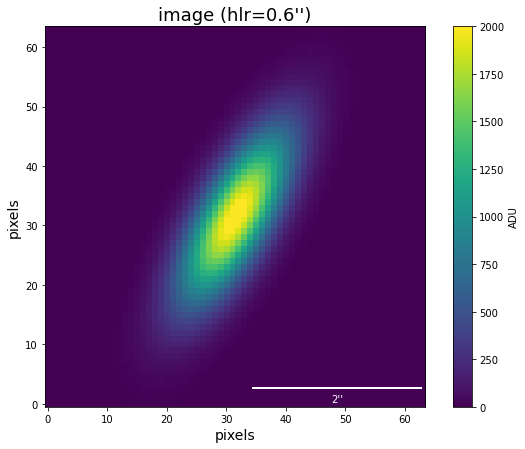

In [5]:
# only assign the variables that are different
p0.psf_fwhm=0
p0.title='image (hlr='+str(p0.gal_hlr)+'\'\')'

# e1, e2, mom_size = get_shape(1,np.array([0,0]),np.array([0,0]),p0.e1,p0.e2,p0.gal_hlr)

# print(e1, e2, p0.e1, p0.e2) 
# print(mom_size, gal_sigma)

array_original = draw_gal(p0)

#### GalSim-convolved image

preshear hlr created in galsim draw: 0.54047
hlr_drawn, moment radius = 0.8022707703628297 0.6659826888645111


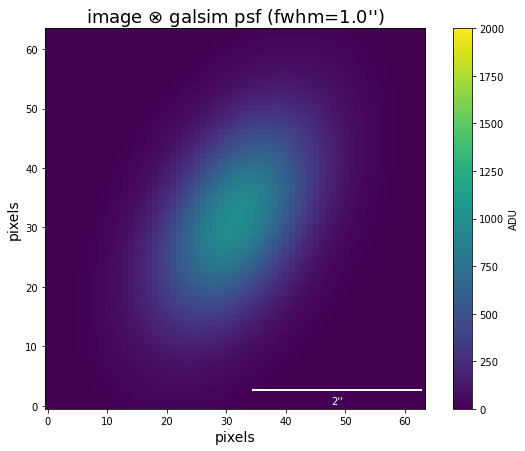

In [6]:
p1 = p0.copy()

p1.psf_fwhm=1.0
p1.title='image $\otimes$ galsim psf (fwhm='+str(p1.psf_fwhm)+'\'\')'

array_galsim_conv = draw_gal(p1)

#### Analitically-convolved image

convolved hlr = 0.8054570904666971
preshear hlr created in galsim draw: 0.78383
hlr_drawn, moment radius = 0.802270770362806 0.6659826888638585


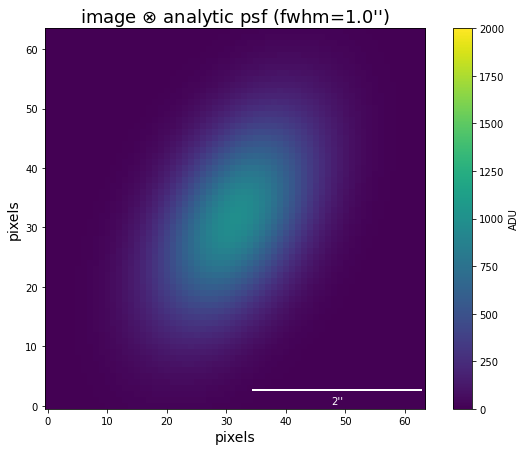

In [7]:
p2 = p0.copy()
p2.psf_fwhm = None # because we apply psf analytically!

psf_fwhm = 1.0 # to be applied analytically
p2.title=r'image $\otimes$ analytic psf (fwhm='+str(psf_fwhm)+'\'\')'
p2.e1, p2.e2, p2.gal_hlr = convolve_with_PSF(1,p0.e1,p0.e2,p0.gal_hlr,PSF_FWHM=psf_fwhm)

print(f'convolved hlr = {p2.gal_hlr}')
array_analytic_conv = draw_gal(p2)

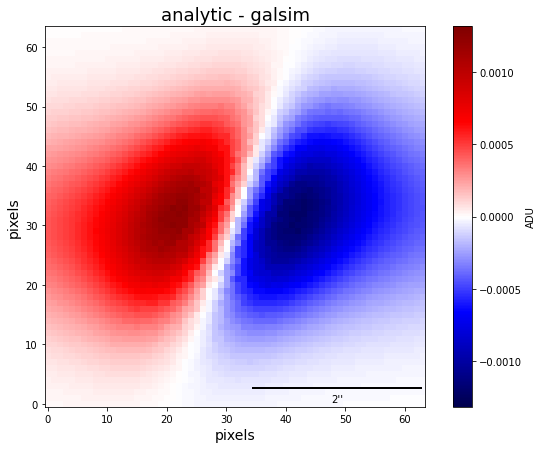

In [8]:
# draw the difference
fig = plt.figure(figsize=(10,7))
err = (array_analytic_conv - array_galsim_conv) #/array_galsim_conv
maxabs = max(np.abs(err.max()), np.abs(err.min()))
plt.imshow(err,origin='lower',cmap='seismic') #,vmin=-9e-4,vmax=9e-4)
plt.title('analytic - galsim',fontsize=18)
plt.xlabel('pixels',fontsize=14)
plt.ylabel('pixels',fontsize=14)
plt.colorbar(label='ADU')
plt.clim([-maxabs*1.05,maxabs*1.05])

scalebar = ScaleBar(1,'px', PIXEL_LENGTH, location='lower right',
                    frameon=False, fixed_value=p0.scalebar_value/p0.pixel_scale,
                    label_formatter = lambda x, y: str(p0.scalebar_value)+'\'\'',
                    height_fraction=0.006, color='black') 
plt.gca().add_artist(scalebar)

Text(0, 0.5, 'frequency')

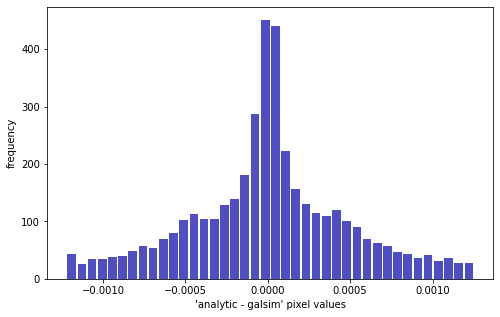

In [9]:
fig = plt.figure(figsize=(8,5))
difference_vector = (array_analytic_conv - array_galsim_conv).flatten()
n, bins, patches = plt.hist(x=difference_vector, bins=40,
                            color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('\'analytic - galsim\' pixel values')
plt.ylabel('frequency')